In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
#If you're not familiar with this, save it. Makes using jupyter notebook on laptops much easier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\Ritwick Perala\AppData\Local\Temp\ipykernel_13372\2126890664.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Data Preparation

In [4]:
spotify_df = pd.read_csv('data.csv')

In [5]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [6]:
spotify_df.shape

(170653, 19)

In [7]:
spotify_df.dtypes

valence             float64
year                  int64
acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
dtype: object

In [8]:
data_w_genre = pd.read_csv('data_w_genres.csv')
data_w_genre.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


In [9]:
data_w_genre.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

In [10]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [11]:
#To check if this is actually a list, let me index it and see what it returns
data_w_genre['genres'].values[0][0]

'['

In [12]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [13]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

In [14]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))

In [15]:
spotify_df['artists'].values[0]

"['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

In [16]:
spotify_df['artists_upd_v1'].values[0][0]

'Sergei Rachmaninoff'

In [17]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1
143,0.300,1921,0.772,"[""Scarlet D'Carpio""]",0.560,249370,0.313,0,7b4eHImKQ51DYaQvNTdtEp,0.000005,6,0.115,-8.346,0,Himno Nacional del Perú,0,1921-09-23,0.0376,107.501,[]
234,0.902,1923,0.994,"[""King Oliver's Creole Jazz Band""]",0.708,194533,0.361,0,1xEEYhWxT4WhDQdxfPCT8D,0.883000,0,0.103,-11.764,0,Snake Rag,20,1923,0.0441,105.695,[]
238,0.554,1923,0.996,"[""King Oliver's Creole Jazz Band""]",0.546,170827,0.189,0,3rauXVLOOM5BlxWqUcDpkg,0.908000,0,0.339,-15.984,1,Chimes Blues,13,1923,0.0581,80.318,[]
244,0.319,1923,0.995,"[""Clarence Williams' Blue Five""]",0.520,197493,0.153,0,1UdqHVRFYMZKU2Q7xkLtYc,0.131000,0,0.353,-14.042,1,Pickin' On Your Baby,11,1923,0.0440,102.937,[]
249,0.753,1923,0.994,"[""King Oliver's Creole Jazz Band""]",0.359,187227,0.357,0,5SvyP1ZeJX1jA7AOZD08NA,0.819000,3,0.290,-11.810,1,Tears,10,1923,0.0511,205.053,[]


In [18]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [19]:
#need to create my own song identifier because there are duplicates of the same song with different ids. I see different
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [20]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [21]:
spotify_df[spotify_df['name']=='Adore You']

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
19425,0.569,2019,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,...,1,Adore You,88,2019-12-13,0.0483,99.048,[Harry Styles],[],[Harry Styles],Harry StylesAdore You
38319,0.569,2019,0.0237,['Harry Styles'],0.676,207133,0.771,0,1M4qEo4HE3PRaCOM7EXNJq,0.000007,...,1,Adore You,77,2019-12-06,0.0483,99.048,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


In [22]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [23]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [24]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='6KuQTIu1KoTTkLXKrwlLPV']

,artists_upd,id,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres_upd
55409,Robert Schumann,6KuQTIu1KoTTkLXKrwlLPV,"['classical', 'early romantic era', 'german ro...",Robert Schumann,0.985304,0.362467,212896.341667,0.102329,0.783424,0.154049,-22.896354,0.047962,97.550958,0.274555,3.195833,5.0,1.0,240.0,"[classical, early_romantic_era, german_romanti..."
55410,Vladimir Horowitz,6KuQTIu1KoTTkLXKrwlLPV,"['classical', 'classical performance', 'classi...",Vladimir Horowitz,0.990092,0.343624,266650.370833,0.118341,0.879898,0.182788,-23.190868,0.043228,94.845258,0.224994,3.694167,1.0,1.0,1200.0,"[classical, classical_performance, classical_p..."


In [25]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [26]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [27]:
artists_genres_consolidated.head()

,id,genres_upd,consolidates_genre_lists
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_wave, new_wave_po...","[new_wave, permanent_wave, power_pop, candy_po..."
1,000GyYHG4uWmlXieKLij8u,"[[alternative_hip_hop, conscious_hip_hop, minn...","[conscious_hip_hop, minnesota_hip_hop, pop_rap..."
2,000Npgk5e2SgwGaIsN3ztv,"[[classic_bollywood, classic_pakistani_pop, fi...","[classic_pakistani_pop, filmi, classic_bollywo..."
3,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, ragtime, stride]]","[ragtime, piano_blues, boogie-woogie, stride]"
4,000jBcNljWTnyjB4YO7ojf,[[]],[]


In [28]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

In [29]:
spotify_df = spotify_df.drop_duplicates(subset='artists_song', keep='first')

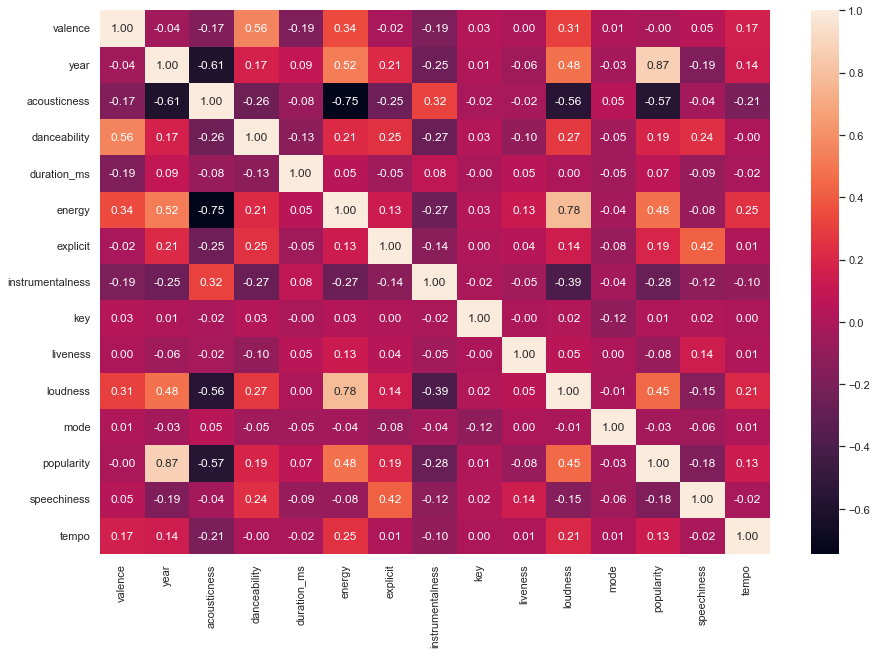

In [30]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(spotify_df.corr(), annot=True, fmt=".2f",);

C:\Users\Ritwick Perala\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ritwick Perala\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ritwick Perala\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

<AxesSubplot:xlabel='mode', ylabel='Density'>

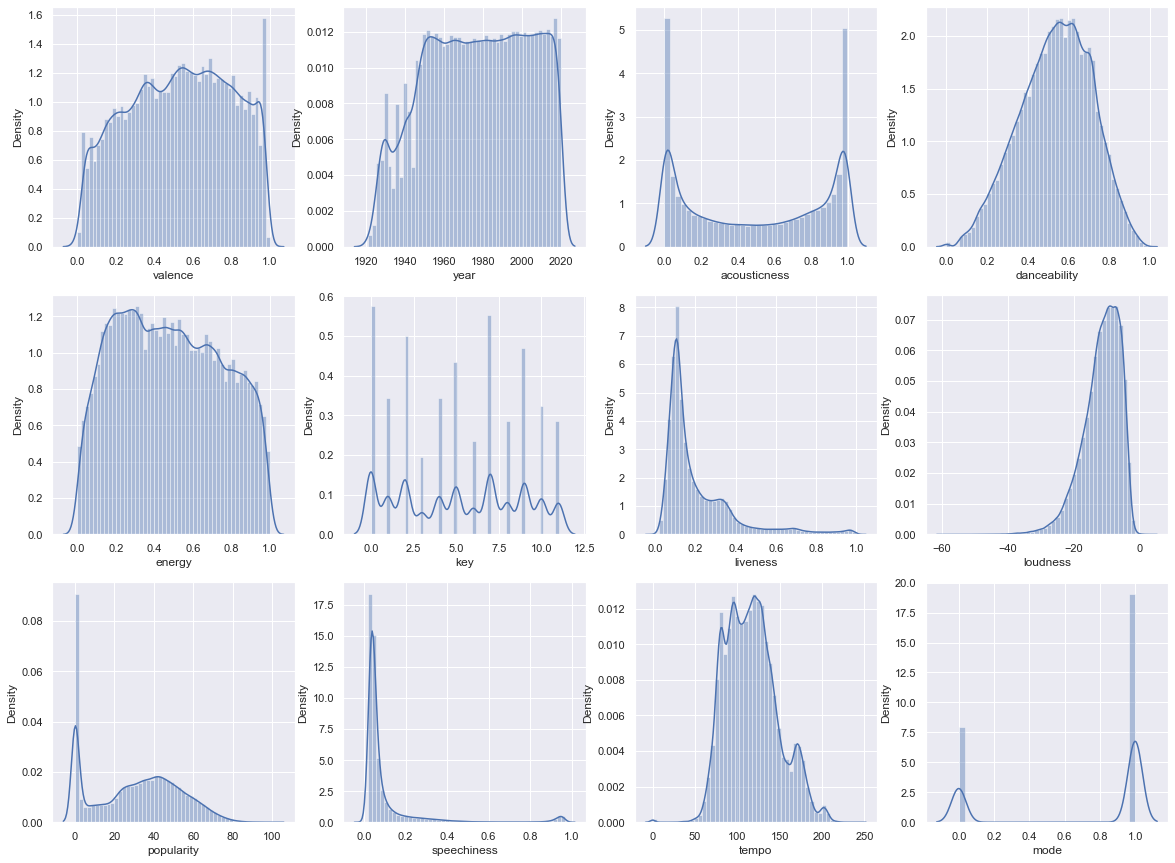

In [31]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

sns.distplot(spotify_df['valence'], ax=ax[0, 0])
sns.distplot(spotify_df['year'], ax=ax[0, 1])
sns.distplot(spotify_df['acousticness'], ax=ax[0, 2])
sns.distplot(spotify_df['danceability'], ax=ax[0, 3])
sns.distplot(spotify_df['energy'], ax=ax[1, 0])
sns.distplot(spotify_df['key'], ax=ax[1, 1])
sns.distplot(spotify_df['liveness'], ax=ax[1, 2])
sns.distplot(spotify_df['loudness'], ax=ax[1, 3])
sns.distplot(spotify_df['popularity'], ax=ax[2, 0])
sns.distplot(spotify_df['speechiness'], ax=ax[2, 1])
sns.distplot(spotify_df['tempo'], ax=ax[2, 2])
sns.distplot(spotify_df['mode'], ax=ax[2, 3])

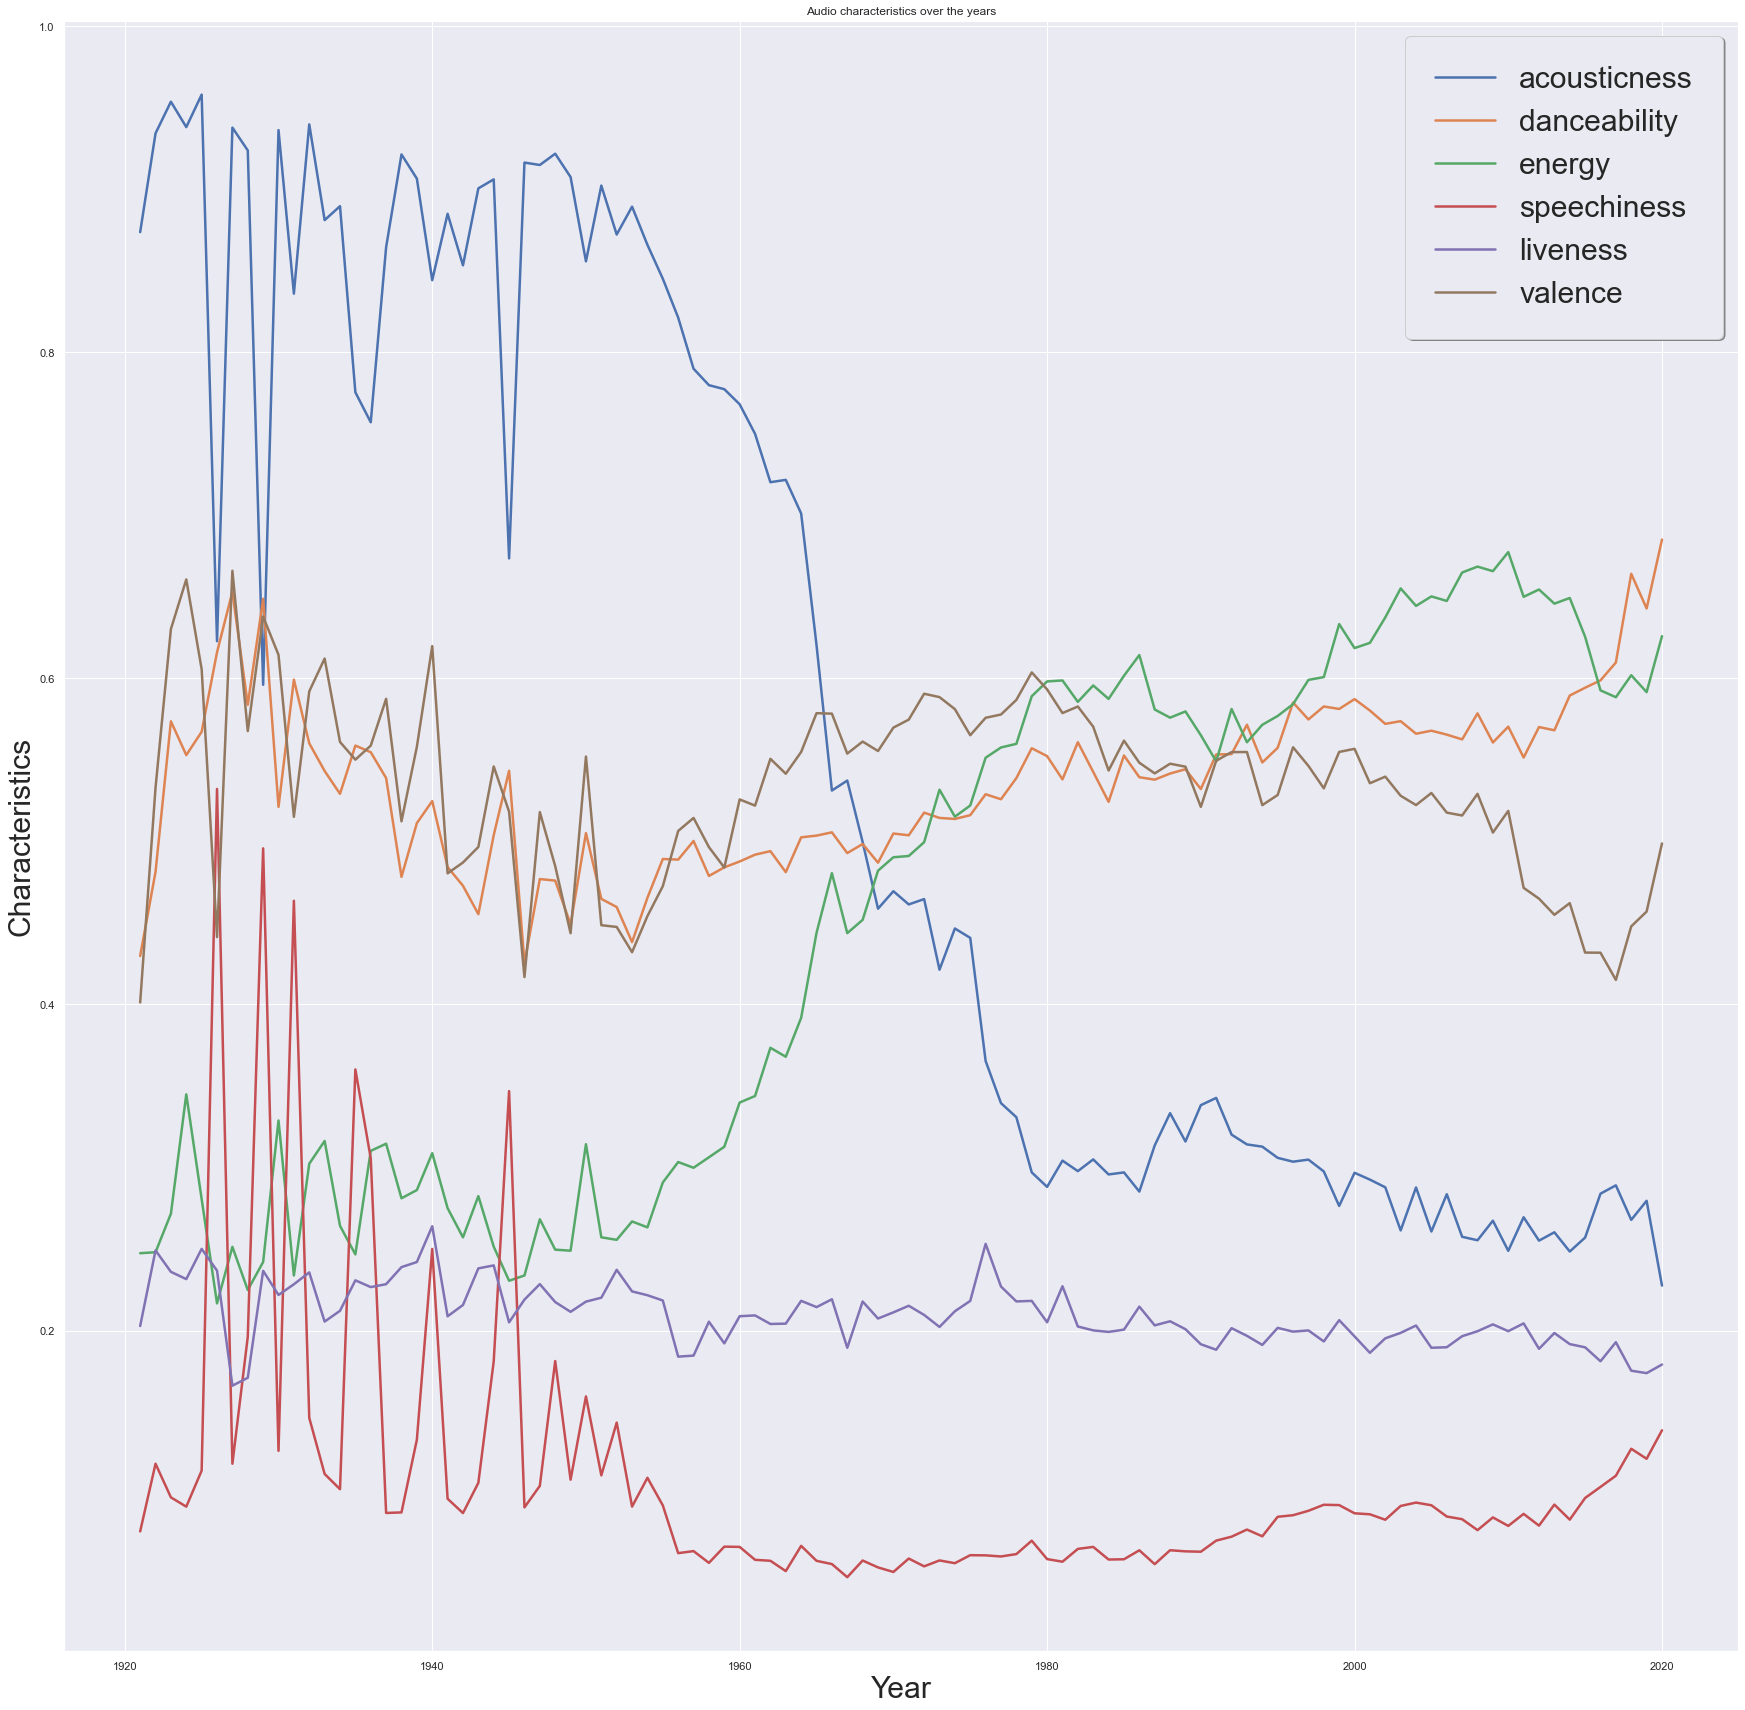

In [32]:
columns = ["acousticness", "danceability", "energy", "speechiness", "liveness", "valence"]
plt.figure(figsize=(30, 30))
for c in columns:
    x = spotify_df.groupby('year')[c].mean()
    sns.lineplot(x=x.index, y=x, label=c, linewidth=2.5)  # Setting linewidth to 2.5 for thicker lines
plt.title('Audio characteristics over the years')
plt.xlabel('Year', fontsize=30)
plt.ylabel('Characteristics', fontsize=30)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, prop={'size': 30}, loc='upper right')
plt.show()


## Feature Engineering

In [33]:
spotify_df.tail()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists
170647,0.768,1997,0.2820,"[""Lil' Kim"", ""Lil' Cease""]",0.748,275947,0.693,0,2LP2uDQQ7eLMcUVE4aOpAV,0.00000,...,Crush on You (feat. Lil' Cease) - Remix,56,1997-06-30,0.2780,88.802,"[ Kim"", ""Lil]","[Lil' Kim, Lil' Cease]","[ Kim"", ""Lil]","Kim"", ""LilCrush on You (feat. Lil' Cease) - R...",NaN
170648,0.792,2004,0.0248,"[""Lil' Flip"", 'Lea']",0.814,225173,0.387,1,4s0o8TJHfX9LLHa0umnOzT,0.00000,...,Sunshine (feat. Lea),62,2004-03-30,0.0945,93.961,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)",NaN
170650,0.697,1999,0.0516,"[""Ol' Dirty Bastard"", 'Kelis', 'Rich Travali']",0.934,239547,0.459,1,6YYd5MLpu45J0uLrMdivF7,0.00000,...,Got Your Money (feat. Kelis),66,1999,0.1890,103.040,"[ Dirty Bastard"", , , ]",[Ol' Dirty Bastard],"[ Dirty Bastard"", , , ]","Dirty Bastard"", Got Your Money (feat. Kelis)",NaN
170651,0.429,1994,0.0249,"[""World Class Wreckin' Cru"", ""Michel 'Le""]",0.715,351040,0.490,0,3hoiinUc5VA9xUEJID7R8V,0.00017,...,Turn Off The Lights - Rap,36,1994-04-06,0.0479,129.309,"[ Cru"", ""Michel ]","[World Class Wreckin' Cru, Michel 'Le]","[ Cru"", ""Michel ]","Cru"", ""Michel Turn Off The Lights - Rap",NaN
170652,0.273,1996,0.0113,"[""Rappin' 4-Tay"", 'MC Breed', 'Too $hort']",0.897,337973,0.414,1,78859Af0fmA9VTlgnOHTAP,0.00011,...,Never Talk Down,35,1996,0.2460,96.039,"[ 4-Tay"", , , ]",[Rappin' 4-Tay],"[ 4-Tay"", , , ]","4-Tay"", Never Talk Down",NaN


In [34]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [35]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [36]:
ohe_cols = 'popularity'

In [37]:
spotify_df['popularity'].describe()

count    156607.000000
mean         31.307215
std          21.712234
min           0.000000
25%          11.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

In [38]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [39]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [40]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red
0,0.177,1989,0.568,['조정현'],0.447,237688,0.2150,0,2ghebdwe2pNXT4eL34T7pW,0.000001,...,31,1989-06-15,0.0272,71.979,[조정현],[],[조정현],조정현그아픔까지사랑한거야,[classic_korean_pop],6
1,0.352,1992,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,...,35,1992-12-22,0.0395,200.341,[黑豹],[],[黑豹],黑豹DON'T BREAK MY HEART,"[chinese_indie_rock, chinese_indie]",7
2,0.458,1963,0.987,['黃國隆'],0.241,193480,0.0437,0,4prhqrLXYMjHJ6vpRAlasx,0.000453,...,23,1963-05-28,0.0443,85.936,[黃國隆],[],[黃國隆],黃國隆藝旦調,[],4
3,0.796,1963,0.852,"['黃國隆', '王秋玉']",0.711,145720,0.1110,0,5xFXTvnEe03SyvFpo6pEaE,0.000000,...,23,1963-05-28,0.0697,124.273,"[黃國隆, 王秋玉]",[],"[黃國隆, 王秋玉]",黃國隆草螟弄雞公,[],4
4,0.704,1963,0.771,['黃國隆'],0.610,208760,0.1750,0,6Pqs2suXEqCGx7Lxg5dlrB,0.000000,...,23,1963-05-28,0.0419,124.662,[黃國隆],[],[黃國隆],黃國隆思想起,[],4


In [41]:


#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df



In [42]:


#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final



In [43]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)

C:\Users\Ritwick Perala\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
complete_feature_set.head()

,genre|21st_century_classical,genre|432hz,genre|_hip_hop,genre|a_cappella,genre|abstract,genre|abstract_beats,genre|abstract_hip_hop,genre|accordeon,genre|accordion,genre|acid_house,...,year|2012,year|2013,year|2014,year|2015,year|2016,year|2017,year|2018,year|2019,year|2020,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2ghebdwe2pNXT4eL34T7pW
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3KIuCzckjdeeVuswPo20mC
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4prhqrLXYMjHJ6vpRAlasx
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5xFXTvnEe03SyvFpo6pEaE
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6Pqs2suXEqCGx7Lxg5dlrB


In [45]:
#client id and secret for my application
client_id = '9f9f64a097d4471fa69ac6ec3f312f41'
client_secret= '890bb4b176824f06983994345df21f20'

In [46]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [47]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [48]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')

In [49]:
sp = spotipy.Spotify(auth=token)

In [50]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [51]:
id_name

{"If love is the answer, you're home, hold on": '3INNCpgVaT0LKOLPbZ59z1',
 'My cluttered list': '5FsXZsFsyiDzYHPOgtrESA',
 'And so Sally can wait': '4fLOLkb5wAgQjOeEe4ZfZc',
 "I'm going back to 505": '4m6GSSqdWCUKH34zXfcCmn',
 'Non, je ne pleurerai pas': '6tXjDMxCqnpgrTjy2103Cv',
 'There will be an answer, let it be': '0YdlzMP8OLCY1WAseAf49u',
 'Mind my wicked words and tipsy topsy slurs': '5KYVDtyiy4pgus7JDKTrxA',
 "What is this feeling that I can't explain?": '2XrejR4GTHsKR85wEH5dW6',
 'Running my fingers through your hair': '7FM0QQZkr7tbhz8VrlEW8P',
 "Let's dance to some classics!": '0SpZJZGXuyeNyQkRP2BQ62',
 'My Sam Smith/Adele/Lewis Capaldi list': '0lhRH6kWyuVin04et0CZKy',
 "I've lost myself in this virtual world": '76aamuEePLMjEUKYsrKMyd',
 'Drums please, Fab': '1yBZDSd0YNM5H2IsagZ8ND'}

In [52]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id']
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [53]:
playlist_input = create_necessary_outputs('My Sam Smith/Adele/Lewis Capaldi list', id_name,spotify_df)

In [54]:
playlist_input

,artist,name,id,url,date_added
19,Adele,Hello,4sPmO7WMQUAf45kwMOtONw,https://i.scdn.co/image/ab67616d00001e024c3bbc...,2020-12-23 14:07:23+00:00
14,Adele,Rumour Has It,76N7FdzCI9OsiUnzJVLY2m,https://i.scdn.co/image/ab67616d00001e026d4056...,2020-12-23 14:07:12+00:00
9,Lewis Capaldi,Hold Me While You Wait,60iSKGrGazRzICtMjADNSM,https://i.scdn.co/image/ab67616d00001e02fc2101...,2020-12-23 14:06:48+00:00
5,Sam Smith,Stay With Me,5Nm9ERjJZ5oyfXZTECKmRt,https://i.scdn.co/image/ab67616d00001e02b11bdc...,2020-12-23 14:06:16+00:00
4,Sam Smith,I'm Not The Only One,7795WJLVKJoAyVoOtCWqXN,https://i.scdn.co/image/ab67616d00001e02b11bdc...,2020-12-23 14:06:13+00:00
3,Sam Smith,Money On My Mind,5XX9oGZfgKMXdHnEp4t2JB,https://i.scdn.co/image/ab67616d00001e02b11bdc...,2020-12-23 14:06:08+00:00
1,Sam Smith,How Do You Sleep?,6b2RcmUt1g9N9mQ3CbjX2Y,https://i.scdn.co/image/ab67616d00001e0276bc1c...,2020-12-23 14:06:01+00:00
0,Sam Smith,Dancing With A Stranger (with Normani),6Qs4SXO9dwPj5GKvVOv8Ki,https://i.scdn.co/image/ab67616d00001e023b52ec...,2020-12-23 14:05:56+00:00


In [55]:


def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist



In [56]:
complete_feature_set_playlist_vector, complete_feature_set_nonplaylist = generate_playlist_feature(complete_feature_set, playlist_input, 0.9)

In [57]:
complete_feature_set_playlist_vector.shape

(3070,)

In [58]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [59]:
Top_rec = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector, complete_feature_set_nonplaylist)

C:\Users\Ritwick Perala\AppData\Local\Temp\ipykernel_13372\2672743570.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]


In [60]:
Top_rec

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red,sim,url
131116,0.591,2014,0.4740,['Ed Sheeran'],0.781,281560,0.4450,0,34gCuhDGsG4bRPIf9bb02f,0.000000,...,0.0295,78.998,[Ed Sheeran],[],[Ed Sheeran],Ed SheeranThinking out Loud,"[pop, uk_pop]",16,0.920073,https://i.scdn.co/image/ab67616d00001e0213b3e3...
131135,0.201,2014,0.6070,['Ed Sheeran'],0.614,258987,0.3790,0,1HNkqx9Ahdgi1Ixy2xkKkL,0.000464,...,0.0476,107.989,[Ed Sheeran],[],[Ed Sheeran],Ed SheeranPhotograph,"[pop, uk_pop]",16,0.918087,https://i.scdn.co/image/ab67616d00001e0213b3e3...
41595,0.481,2014,0.3430,['Sam Smith'],0.656,167066,0.6270,0,2TeLIzFBe3hxkPR5FIQZut,0.000022,...,0.0379,99.933,[Sam Smith],[],[Sam Smith],Sam SmithLike I Can,"[pop, uk_pop]",13,0.913671,https://i.scdn.co/image/ab67616d00001e02b11bdc...
131148,0.336,2014,0.5560,['Ed Sheeran'],0.697,244573,0.3770,0,0xCA70t1ZA4fa9UOE0lIJm,0.000000,...,0.0397,138.754,[Ed Sheeran],[],[Ed Sheeran],Ed SheeranI'm a Mess,"[pop, uk_pop]",13,0.912505,https://i.scdn.co/image/ab67616d00001e0213b3e3...
131128,0.939,2014,0.3040,['Ed Sheeran'],0.818,235382,0.6700,0,6K8qKeWo5MsFED7wCR6Kop,0.000001,...,0.0472,119.988,[Ed Sheeran],[],[Ed Sheeran],Ed SheeranSing,"[pop, uk_pop]",13,0.911837,https://i.scdn.co/image/ab67616d00001e0213b3e3...
81038,0.488,2019,0.4350,['Lewis Capaldi'],0.722,185658,0.5650,0,0pEkK8MqbmGSX7fT8WLMbR,0.000000,...,0.0335,104.483,[Lewis Capaldi],[],[Lewis Capaldi],Lewis CapaldiGrace,"[pop, uk_pop]",14,0.911677,https://i.scdn.co/image/ab67616d00001e02fc2101...
131166,0.543,2014,0.5290,['Ed Sheeran'],0.660,300253,0.3160,0,5v4sZRuvWDcisoOk1PFv6T,0.000294,...,0.0364,91.207,[Ed Sheeran],[],[Ed Sheeran],Ed SheeranBloodstream,"[pop, uk_pop]",13,0.910917,https://i.scdn.co/image/ab67616d00001e0213b3e3...
81034,0.382,2019,0.8890,['Lewis Capaldi'],0.555,197179,0.2820,0,6glNKSv2aUtfQhe1SJBZZt,0.000000,...,0.0612,125.522,[Lewis Capaldi],[],[Lewis Capaldi],Lewis CapaldiLost On You,"[pop, uk_pop]",13,0.909246,https://i.scdn.co/image/ab67616d00001e02fc2101...
81033,0.512,2019,0.8340,['Lewis Capaldi'],0.708,179908,0.3390,0,5C1TucCRf4Vjjree1OItyv,0.000000,...,0.0409,117.995,[Lewis Capaldi],[],[Lewis Capaldi],Lewis CapaldiOne,"[pop, uk_pop]",14,0.908898,https://i.scdn.co/image/ab67616d00001e02fc2101...
81035,0.135,2019,0.6500,['Lewis Capaldi'],0.409,210213,0.4460,0,1NxHgM5nOnmqi3KUVLbaIw,0.000000,...,0.0317,75.638,[Lewis Capaldi],[],[Lewis Capaldi],Lewis CapaldiLeaving My Love Behind,"[pop, uk_pop]",13,0.908896,https://i.scdn.co/image/ab67616d00001e027b9639...
